In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dgr_bert_model import *
from dgr_vae_model import *
from dgr_utils import *
from dgr_linear_classifier import *
from dgr_training import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
# dataset from external context
train_external_dataset_path = "data/PMC_train.jsonl"
test_external_dataset_path = "data/PMC_test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

sample_column_name = "string"
columns_to_keep = ['string', 'label']

# Load dataset
df_train = load_dataset_raw(train_external_dataset_path, sample_column=sample_column_name,
                            columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_external_dataset_path, sample_column=sample_column_name,
                           columns_to_keep=columns_to_keep)

unique_labels = df_train['label'].unique()

In [5]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# processing the dataset
print("Processing train external dataset...")
texts_train, labels_train = process_data_bert(df_train, label_to_index)

print("Processing test external dataset...")
texts_test, labels_test = process_data_bert(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train external dataset...


100%|██████████| 3412/3412 [00:00<00:00, 22746.80it/s]


Processing test external dataset...


100%|██████████| 863/863 [00:00<00:00, 20068.44it/s]

Total number of training samples: 3412
Total number of test samples: 863


In [7]:
max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

In [8]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [9]:
counts = torch.bincount(train_y)
print(counts)

tensor([2241,  718,  453])


In [10]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
bert_lstm = BertLSTM(bert_model)
bert_lstm = bert_lstm.to(device)

print(bert_lstm)

BertLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [12]:
class_weights = torch.tensor([1 / counts[0].item(), 
                              1 / counts[1].item(), 
                              1 / counts[2].item()]).to(device)

criterion  = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(bert_lstm.parameters(), lr=0.0005)

In [13]:
num_epochs = 10

results = train_bert(bert_lstm, train_dataloader, val_dataloader, 
                optimizer, criterion, num_epochs, device, verbose=True)

Total Training Time (total number of epochs: 10)


100%|██████████| 27/27 [00:06<00:00,  4.32it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 1] loss:	112.430, f1 train: 0.632, f1 test: 0.595 


100%|██████████| 27/27 [00:06<00:00,  4.30it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 2] loss:	102.298, f1 train: 0.669, f1 test: 0.646 


100%|██████████| 27/27 [00:06<00:00,  4.33it/s]


[Epoch 3] loss:	99.619, f1 train: 0.534, f1 test: 0.485 


100%|██████████| 27/27 [00:06<00:00,  4.32it/s]


[Epoch 4] loss:	94.227, f1 train: 0.711, f1 test: 0.633 


100%|██████████| 27/27 [00:06<00:00,  4.32it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 5] loss:	93.173, f1 train: 0.738, f1 test: 0.666 


100%|██████████| 27/27 [00:06<00:00,  4.33it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 6] loss:	88.815, f1 train: 0.755, f1 test: 0.668 


100%|██████████| 27/27 [00:06<00:00,  4.30it/s]


saving model checkpoint to data/model_bert.pth
[Epoch 7] loss:	87.251, f1 train: 0.775, f1 test: 0.670 


100%|██████████| 27/27 [00:06<00:00,  4.24it/s]


[Epoch 8] loss:	79.128, f1 train: 0.794, f1 test: 0.647 


100%|██████████| 27/27 [00:06<00:00,  4.28it/s]


[Epoch 9] loss:	81.516, f1 train: 0.791, f1 test: 0.639 


100%|██████████| 27/27 [00:06<00:00,  4.39it/s]

[Epoch 10] loss:	77.932, f1 train: 0.820, f1 test: 0.666 


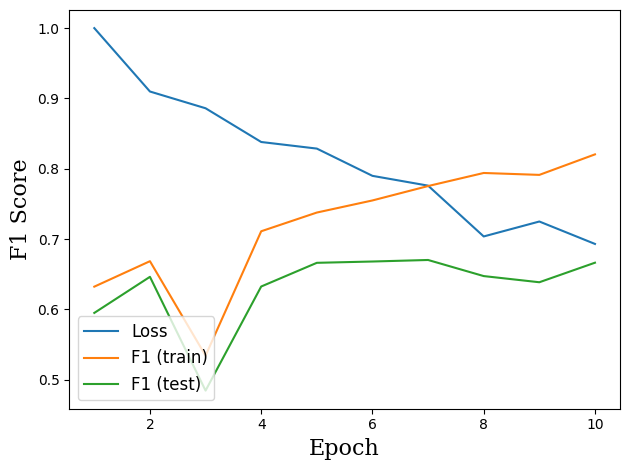

In [14]:
plot_training_results(results)

100%|██████████| 27/27 [00:06<00:00,  4.36it/s]

Evaluating model: data/context2_bert.pth
F1 score for model: 0.668


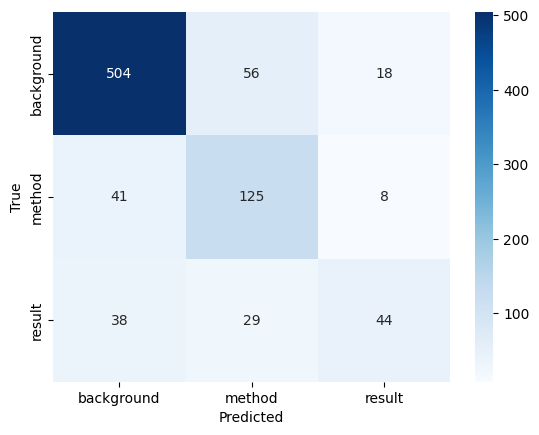

              precision    recall  f1-score   support

  background       0.86      0.87      0.87       578
      method       0.60      0.72      0.65       174
      result       0.63      0.40      0.49       111

    accuracy                           0.78       863
   macro avg       0.70      0.66      0.67       863
weighted avg       0.78      0.78      0.78       863


In [15]:
model_path = 'data/context2_bert.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate_bert(eval_model, val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)